# Algoritmos #
### Introducción ##

Importamos las **librerías** que van a ser necesarias para el desarrollo de las pertinentes acciones en este notebook.

In [1]:
import warnings

from graphviz import Source
from IPython.display import Image
from pandas import Series, DataFrame
from scipy.interpolate import interp1d
from scipy.stats import*
from sklearn import metrics
from sklearn import preprocessing
from sklearn import tree
from sklearn import tree, datasets, svm
from sklearn.cluster import KMeans
from sklearn.cross_validation import train_test_split
from sklearn.externals.six import StringIO
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

import ast
import calendar
import csv
import geocoder
import math
import matplotlib.pylab as plt
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pydot
import pydotplus
import reverse_geocoder as rg
import scipy.fftpack
import seaborn as sns
import sklearn.metrics
import statsmodels.api as sm
import time

C:\Users\grane\Anaconda3\envs\granero\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
warnings.simplefilter("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_row', 100)
inicio = time.strftime("%c")
%matplotlib inline

In [3]:
df_ori = pd.read_csv('.././PreparacionData/dataCleaning.csv', sep = '|', low_memory=False, parse_dates=[['FECHA','TIEMPO']])
df_ori.head()

,FECHA_TIEMPO,ID,AREA,CODIGO_POSTAL,LATITUD,LONGITUD,LOCALIZACION,CALLE1,CALLE2,CALLE3,PERSONA_LESIONADA,PERSONA_MUERTA,PEATON_LESIONADO,PEATON_MUERTO,CICLISTA_LESIONADO,CICLISTA_MUERTO,MOTORISTA_LESIONADO,MOTORISTA_MUERTO,VEHICULO1,VEHICULO2,VEHICULO3,VEHICULO4,VEHICULO5,FACTOR1,FACTOR2,FACTOR3,FACTOR4,FACTOR5
0,2015-01-01 00:20:00,3146911,QUEENS,11358.0,40.751847,-73.787862,"(40.7518471, -73.787862)",47 AVENUE,193 STREET,NaN,0,0,0,0,0,0,0,0,SPORT UTILITY/STATION WAGON,NaN,NaN,NaN,NaN,TRAFFIC CONTROL DISREGARDED,NaN,NaN,NaN,NaN
1,2015-01-01 00:20:00,3146180,MANHATTAN,NaN,40.771289,-73.946693,"(40.7712888, -73.9466928)",NaN,NaN,NaN,1,0,0,0,0,0,1,0,PASSENGER VEHICLE,NaN,NaN,NaN,NaN,ANIMALS ACTION,NaN,NaN,NaN,NaN
2,2015-01-01 00:21:00,3146384,BROOKLYN,11205.0,40.689445,-73.955121,"(40.6894449, -73.9551212)",BEDFORD AVENUE,LAFAYETTE AVENUE,NaN,0,0,0,0,0,0,0,0,PASSENGER VEHICLE,UNKNOWN,NaN,NaN,NaN,FATIGUED/DROWSY,UNSPECIFIED,NaN,NaN,NaN
3,2015-01-01 00:30:00,3146013,BROOKLYN,11213.0,40.673845,-73.925080,"(40.6738445, -73.9250801)",BUFFALO AVENUE,SAINT MARKS AVENUE,NaN,0,0,0,0,0,0,0,0,BUS,PASSENGER VEHICLE,NaN,NaN,NaN,LOST CONSCIOUSNESS,NaN,NaN,NaN,NaN
4,2015-01-01 00:33:00,3146120,STATEN ISLAND,10301.0,NaN,NaN,NaN,RICHMOND TERRACE,SOUTH AVENUE,NaN,0,0,0,0,0,0,0,0,UNKNOWN,PASSENGER VEHICLE,NaN,NaN,NaN,UNSPECIFIED,UNSPECIFIED,NaN,NaN,NaN


In [4]:
df = df_ori.copy()
df['DIASEMANA'] = pd.to_datetime(df['FECHA_TIEMPO']).dt.dayofweek
df['HORA'] = pd.to_datetime(df['FECHA_TIEMPO']).dt.hour
df['MES'] = pd.to_datetime(df['FECHA_TIEMPO']).dt.month
df['DIA'] = pd.to_datetime(df['FECHA_TIEMPO']).dt.day
df['AÑO'] = pd.to_datetime(df['FECHA_TIEMPO']).dt.year
df['MINUTO'] = pd.to_datetime(df['FECHA_TIEMPO']).dt.minute

# Método no Supervisado

### K-means clustering

Para poder trabajar con el algoritmo K-means primero se ha tenido que limpiar el conjunto de datos de cualquier estructura **Not a Number**(NaN).

Debemos eliminar aquellos datos considerados Outlier, estos son valores atípicos que difieren de la relación conjunta de los demás datos y que pueden generar datos engañosos.

Calculamos los límites permitidos para no considerar que el dato es Outlier, mediante la suma de la media y la desviación estandar.

In [5]:
df.dropna(axis=0, how='any', subset=['LATITUD', 'LONGITUD'],inplace = True)
df.reset_index(drop=True, inplace=True)

latitud = []
longitud = []
for i in range(len(df["FECHA_TIEMPO"])):
    latitud.append(df["LATITUD"][i])
    longitud.append(df["LONGITUD"][i])

latitud = np.array(latitud)
longitud = np.array(longitud)

x_upper = latitud.mean() + latitud.std() / 2
x_lower = latitud.mean() - latitud.std() / 2
y_upper = longitud.mean() + 0.5
y_lower = longitud.mean() - 0.5

lat = []
lon = []
if range(len(latitud)) == range(len(longitud)):
    for i in range(len(latitud)):
        if x_lower <= latitud[i] <= x_upper:
            if y_lower <= longitud[i] <= y_upper:
                lat.append(latitud[i])
                lon.append(longitud[i])

X = pd.DataFrame({'LONGITUD': lon,'LATITUD': lat})

Dibujamos el mapa de los distritos recogidos en el dataframe, mediante las posiciones de todas las **latitudes y longitudes**(eje X) que poseemos.

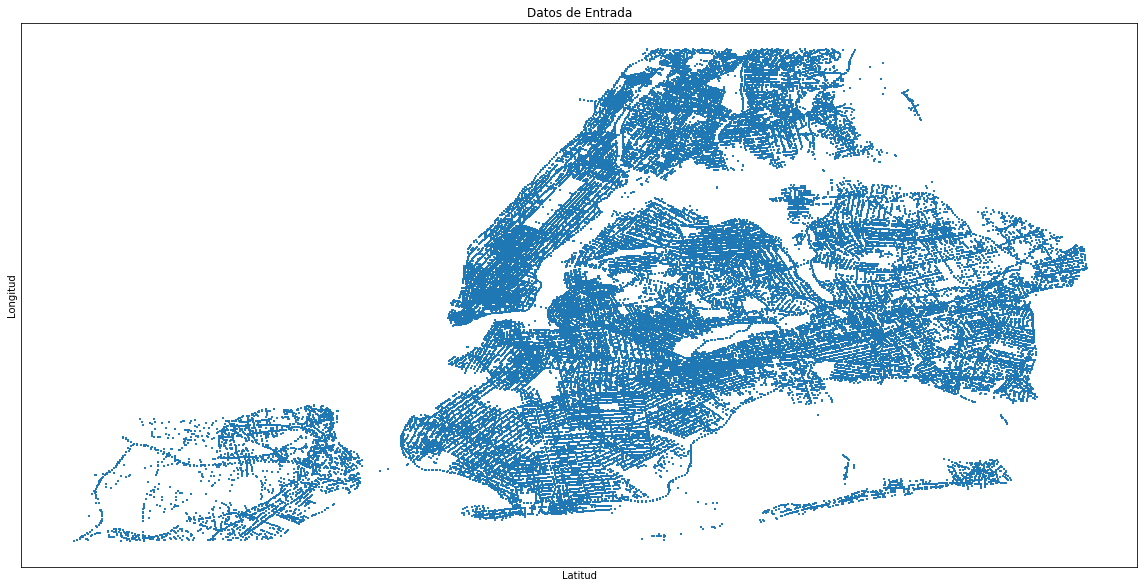

In [6]:
# Plot data
plt.figure(figsize=(20, 10))
plt.title('Datos de Entrada')
plt.ylabel('Longitud')
plt.xlabel('Latitud')
plt.xticks(())
plt.yticks(())
plt.scatter(X.iloc[:,0], X.iloc[:,1], color='#1F77B4',s=1, marker=',')
plt.savefig('.././Imagenes/ANS/ANS_IMAGEN1.png', bbox_inches='tight')
plt.show()

Vamos a necesitar obtener tanto el número **optimo** de k que deberá tener nuestro algoritmo no supervisado como la **incercia**, esta es la suma de las distancias al cuadrado de cada objeto del Cluster a su centroide.

Podemos entender el k óptimo como aquel punto en donde la gráfica del SSE pierde su mayor pendiente.

In [7]:
distorsion = []
K = range(1, 10)

for k in K:
    kmeans = KMeans(n_clusters=k).fit(X)
    centroide = kmeans.cluster_centers_
    distorsion.append(kmeans.inertia_)
    labels = kmeans.labels_

distorsion = [i / sum(distorsion) for i in distorsion]
K = [i / sum(K) for i in K]

distancia = []
for i in range(len(K)):
    distancia.append(math.sqrt((K[i]) ** 2 + (distorsion[i]) ** 2))
    
k = distancia.index(min(distancia)) + 1


Generamos la gráfica del SSE para poder comprobar graficamente cual sería la **k óptima**

La Cte k: 4


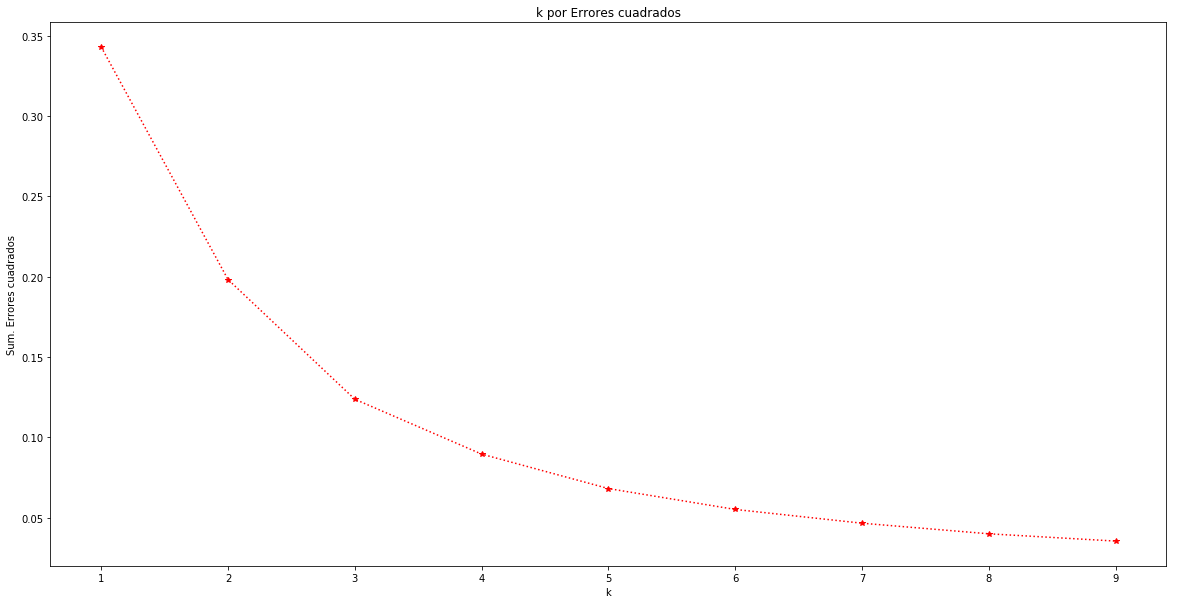

In [8]:
print('La Cte k: ' + str(k))
K = range(1,10)
plt.figure(figsize=(20, 10))
plt.plot(K, distorsion, 'r*:')
plt.xlabel('k')
plt.ylabel('Sum. Errores cuadrados')
plt.title('k por Errores cuadrados')
plt.savefig('.././Imagenes/ANS/ANS_IMAGEN2.png', bbox_inches='tight')
plt.show()

Otra forma de hallar dicho k óptima es la que se define a través de la **Curva de Elbow directamente**, mostrada a continuación.

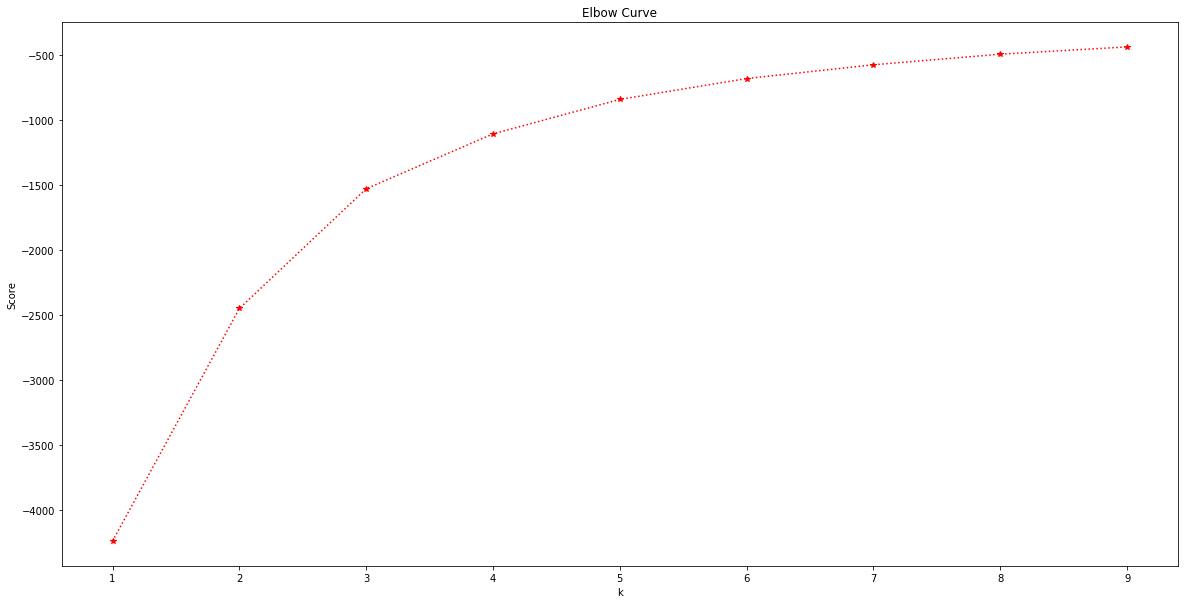

In [9]:
K = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K]
score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
plt.figure(figsize=(20, 10))
plt.plot(K,score,'r*:')
plt.xlabel('k')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.savefig('.././Imagenes/ANS/ANS_IMAGEN3.png', bbox_inches='tight')
plt.show()

Ya conocido el **k** a utilizar, vamos a entrenar el dataframe.

Generamos el gráfico con las coordenadas agrupadas por el valor de los centroides ya entrenados.

La Cte k: 4


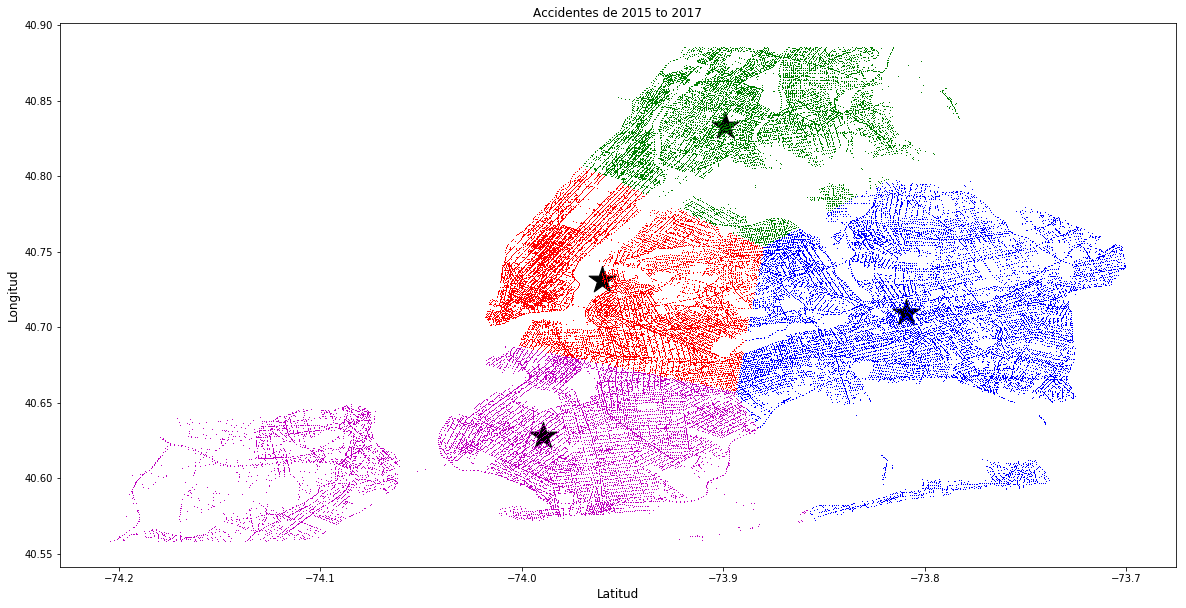

In [10]:
X = pd.DataFrame({'LONGITUD': lon,'LATITUD': lat})
kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
print('La Cte k: ' + str(k))
fmt  = np.array(['b,', 'r,', 'g,', 'm,', 'k,', 'c,', 'y,'])
plt.figure(figsize=(20, 10))
for i in range(k):
    cluster = np.where(kmeans.labels_ == i)[0]
    plt.plot(X['LONGITUD'][cluster].values,X['LATITUD'][cluster].values, fmt [i])
#plt.margins(x=0.2)
plt.ylabel('Longitud', fontsize=12)
plt.xlabel('Latitud', fontsize=12)
plt.title('Accidentes de '+str(2015)+' to '+str(2017), fontsize=12)
plt.scatter(kmeans.cluster_centers_[:,0] ,kmeans.cluster_centers_[:,1], s=800, marker= '*', c='k')
plt.savefig('.././Imagenes/ANS/ANS_IMAGEN4.png', bbox_inches='tight')
plt.show()


Para poder apreciar si el valor **k** es el óptimo, se puede comparar tambien con la puntuación de Silhouette(**Score Silhouette**).
Para ello iteramos un rango de clusters y ejercemos el uso de la funcion de Silhouette mediante el cálculo Euclideano.

In [11]:
# Initialize variables
scores = []
values = np.arange(3, 7)
X = pd.DataFrame({'LONGITUD': lon,'LATITUD': lat})
# Iterate through the defined range
for num_clusters in values:
    # Train the KMeans clustering model
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
    score = metrics.silhouette_score(X, kmeans.labels_, metric='euclidean', sample_size=10000)
    print("\nNúmero de clusters =", num_clusters)
    print("Score Silhouette =", score)
    scores.append(score)



Número de clusters = 3
Score Silhouette = 0.4028861011268799

Número de clusters = 4
Score Silhouette = 0.43664457947606367

Número de clusters = 5
Score Silhouette = 0.42171183177946603

Número de clusters = 6
Score Silhouette = 0.39957563619940556


Apreciamos como para nuestro "k=4", se obtiene el valor máximo de Silhouette.


Número de clusters óptimo = 4


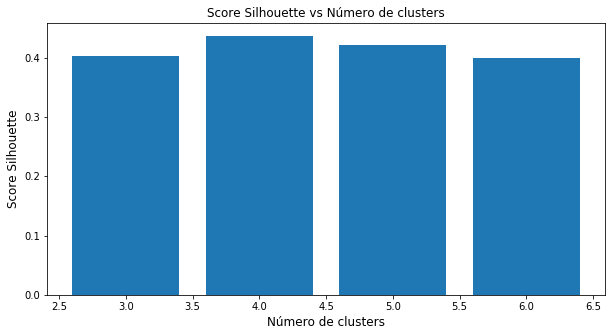

In [12]:
# Extract best score and optimal number of clusters
num_clusters = np.argmax(scores) + values[0]
print('\nNúmero de clusters óptimo =', num_clusters)
plt.figure(figsize=(10, 5))
plt.bar(values, scores, width=0.8, color='#1F77B4', align='center')
plt.ylabel('Score Silhouette', fontsize=12)
plt.xlabel('Número de clusters', fontsize=12)
plt.title('Score Silhouette vs Número de clusters')
plt.savefig('.././Imagenes/ANS/ANS_IMAGEN5.png', bbox_inches='tight')
plt.show()



Con esto daríamos por concluido la parte más analítica del **TFM**.

Para continuar en la realización del mismo se ha implementado un pequeño Dashboard donde poder, a través de una manera más visual, obtener datos empirícos más claros sobre el alcance de los parámetros del dataframe.

In [13]:
fin = time.strftime("%c")
print ("La ejecución completa ha comprendido entre: " + inicio + ' y ' + fin)


La ejecución completa ha comprendido entre: Wed Jun 27 12:07:13 2018 y Wed Jun 27 12:14:53 2018
